# **Classifying Facial Images With CNN and DenseNet121**

This Jupyter Notebook contains code that utilizes 2 different machine learning models, CNN and DenseNet121, for classifying facial images. The data is directly imported from the publicly available dataset - 140k Real and Fake Faces. Link to Dataset: https://www.kaggle.com/datasets/gauravduttakiit/140k-real-and-fake-faces

## **Importing Dataset**

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gauravduttakiit/140k-real-and-fake-faces")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gauravduttakiit/140k-real-and-fake-faces/versions/1


## **Importing Initial Libraries and Setting Device to GPU**

In [ ]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataset_path = path
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

Using device: cuda


## **Creating Class for CNN Model and Pre-trained DenseNet121 Model**

In [ ]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


from torchvision.models import densenet121

pretrained_model = densenet121(pretrained=True)
pretrained_model.classifier = nn.Sequential(
    nn.Linear(pretrained_model.classifier.in_features, 1),
    nn.Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## **Displaying Sample Real and Fake Images from Dataset**

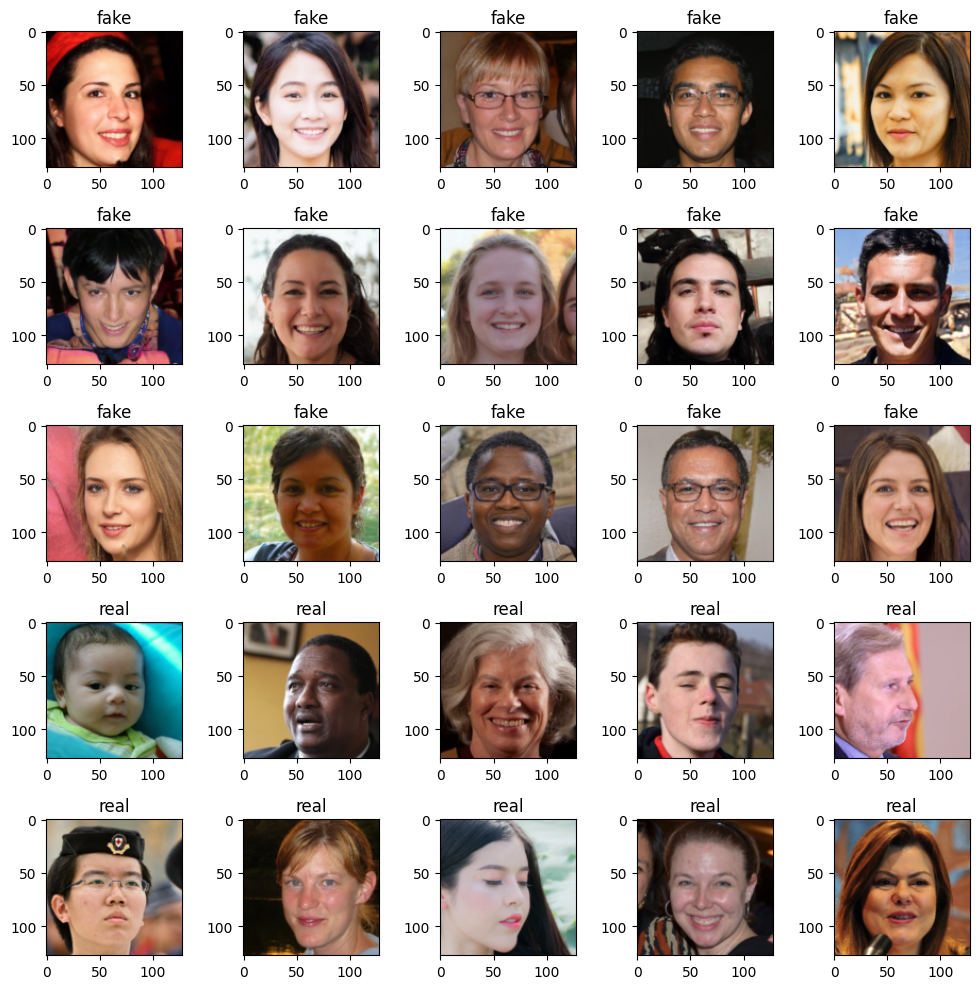

In [ ]:
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "train"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(dataset_path, "test"), transform=transform)

def display_images(dataset, class_names, num_images=25):
    plt.figure(figsize=(10, 10))
    j = 0
    for i in range(num_images):

        image, label = dataset[j]
        image = image.permute(1, 2, 0)

        image = image * 0.5 + 0.5

        plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy())
        plt.title(class_names[label])
        plt.axis("on")
        j += 4000
    plt.tight_layout()
    plt.show()

class_names = train_dataset.classes
display_images(train_dataset, class_names)

## **Creating Train Model Function**

In [ ]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=32):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

        for images, labels in loop:
            images, labels = images.to(device), labels.float().to(device)

            optimizer.zero_grad()

            outputs = model(images).squeeze()

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=running_loss / len(train_loader))

        train_losses.append(running_loss / len(train_loader))
    return train_losses

## **Training DenseNet121 Model**

In [ ]:
##########  DenseNet121 Model Training  ###########
print("DenseNet121 Training Status: ")
train_loader_DenseNet121 = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader_DenseNet121 = DataLoader(test_dataset, batch_size=128, shuffle=False)
pretrained_model = pretrained_model.to(device)
criterion_DenseNet121 = nn.BCELoss()
optimizer_DenseNet121 = optim.Adam(pretrained_model.parameters(), lr=0.001)
train_losses_DenseNet121 = train_model(pretrained_model, train_loader_DenseNet121, criterion_DenseNet121, optimizer_DenseNet121, device, epochs=5)

DenseNet121 Training Status: 


Epoch 5/5: 100%|██████████| 938/938 [07:23<00:00,  2.11it/s, loss=0.0291]


## **Training CNN with Specific Hyperparameters**

In [ ]:
##########  Model 3 Training  ###########
print("CNN Model 3 Training Status: ")
train_loader3 = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader3 = DataLoader(test_dataset, batch_size=64, shuffle=False)
model3 = CNNModel3().to(device)
criterion3 = nn.BCELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)
train_losses3 = train_model(model3, train_loader3, criterion3, optimizer3, device, epochs=3) #Number of Epochs for training.

CNN Model 3 Training Status: 


Epoch 3/3: 100%|██████████| 1875/1875 [06:06<00:00,  5.12it/s, loss=0.197]


## **Defining Model Testing Functions and Graph Plotting Functions**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            predicted = (outputs > 0.5).long()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def evaluate_model_with_probs(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

def plot_training_loss(train_losses, model_name):
    epochs = range(1, len(train_losses) + 1)
    if model_name == "CNNModel3":
        line_color='r'
    else:
        line_color='b'
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color=line_color, marker='o')
    plt.title(f'Training Loss vs Epochs for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    y_ticks = np.arange(0.00, 0.70, 0.05)
    plt.yticks(y_ticks)
    plt.ylim(0.00, 0.65)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_roc_curve(model_probs, true_labels, model_name, line_color):
    fpr, tpr, _ = roc_curve(true_labels, model_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color=line_color, label=f'{model_name} (AUC = {roc_auc:.10f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## **Testing and Displaying Results for DenseNet121 Model**


DenseNet121 Data Visualization
Accuracy: 98.11%


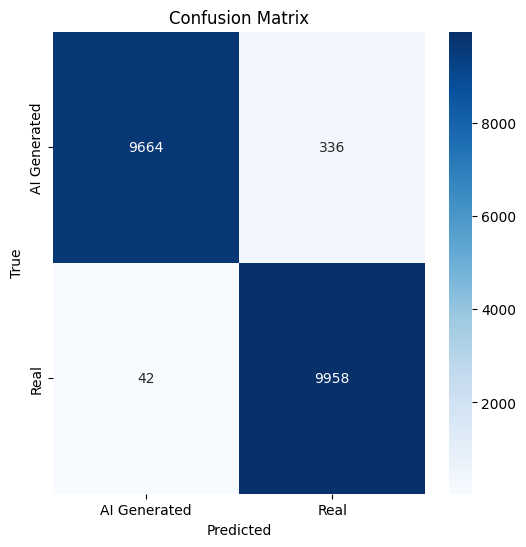

True Positives (TP): 9958
True Negatives (TN): 9664
False Positives (FP): 336
False Negatives (FN): 42

Classification Report:

              precision    recall  f1-score   support

AI Generated       1.00      0.97      0.98     10000
        Real       0.97      1.00      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000




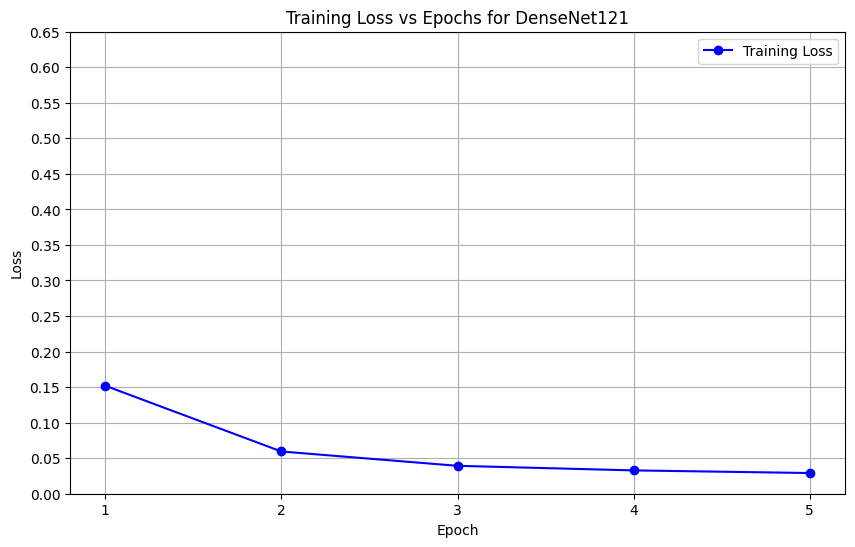

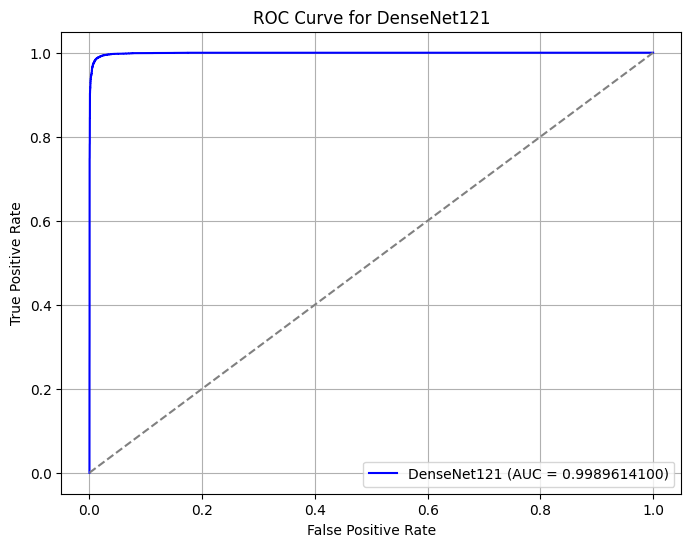

In [ ]:
##########  DenseNet121 Testing  ###########
predictions, true_labels = evaluate_model(pretrained_model, test_loader_DenseNet121, device)
accuracy = accuracy_score(true_labels, predictions)
print()
print("DenseNet121 Data Visualization")
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["AI Generated", "Real"], yticklabels=["AI Generated", "Real"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

TN, FP, FN, TP = cm.ravel()
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print()

report = classification_report(true_labels, predictions, target_names=["AI Generated", "Real"])
print("Classification Report:")
print()
print(report)
print()
plot_training_loss(train_losses_DenseNet121, 'DenseNet121')

print()
densenet_probs, true_labels_densenet = evaluate_model_with_probs(pretrained_model, test_loader_DenseNet121, device)
plot_roc_curve(densenet_probs, true_labels_densenet, 'DenseNet121', "blue")

## **Testing and Displaying Results for CNN Model**


CNN Model 3 Data Visualization
Accuracy: 92.86%


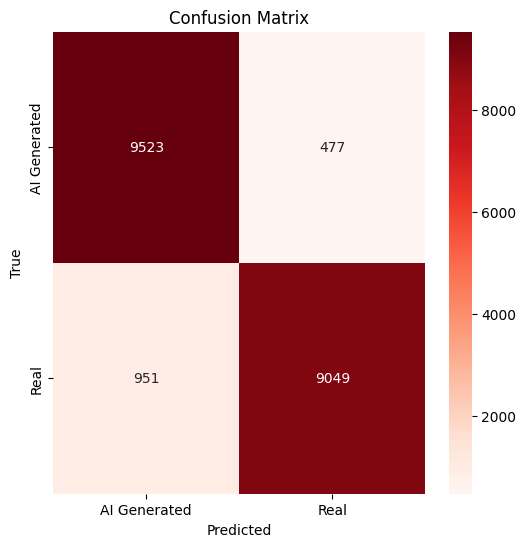

True Positives (TP): 9049
True Negatives (TN): 9523
False Positives (FP): 477
False Negatives (FN): 951

Classification Report:

              precision    recall  f1-score   support

AI Generated       0.91      0.95      0.93     10000
        Real       0.95      0.90      0.93     10000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000




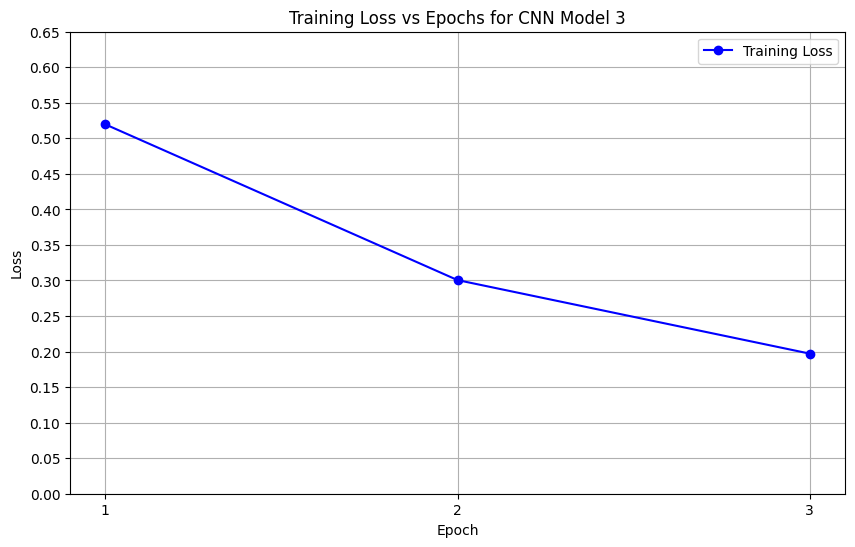

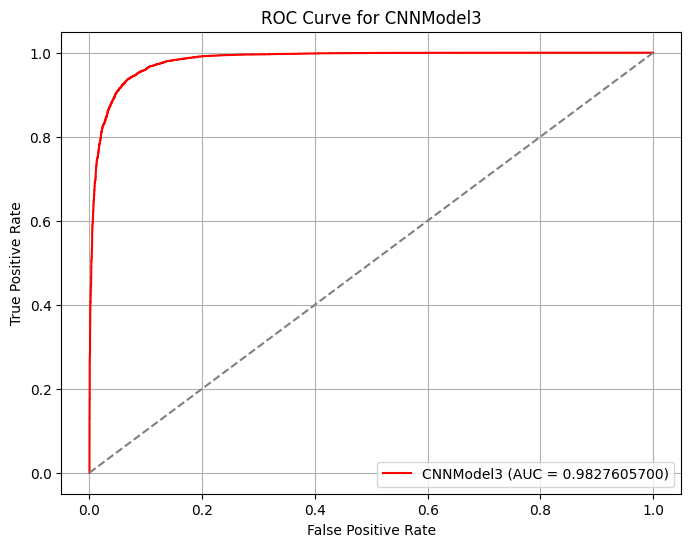

In [ ]:
##########  Model 3 Testing  ###########
predictions, true_labels = evaluate_model(model3, test_loader3, device)
accuracy = accuracy_score(true_labels, predictions)
print()
print("CNN Model 3 Data Visualization")
print(f"Accuracy: {accuracy * 100:.2f}%")

cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=["AI Generated", "Real"], yticklabels=["AI Generated", "Real"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

TN, FP, FN, TP = cm.ravel()
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print()

report = classification_report(true_labels, predictions, target_names=["AI Generated", "Real"])
print("Classification Report:")
print()
print(report)
print()
plot_training_loss(train_losses3, 'CNN Model 3')

print()
cnn_probs, true_labels_cnn = evaluate_model_with_probs(model3, test_loader3, device)
plot_roc_curve(cnn_probs, true_labels_cnn, 'CNNModel3', "red")